In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots
#plt.style.use('ggplot')

rez=600 #pdf resolution

/Users/danielreeves/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
#upload and process the data
thor = pd.read_excel('data/HIV_Integration_Sites_TableS3__corrected_15apr15.xlsx')
thor = thor.dropna() #drop nan row
mald = pd.read_csv('data/pmid24968937_maldarelli.tsv', sep='\t')

#rename because counts is taken in pandas
new_columns = mald.columns.values; 
new_columns[5] = 'site_counts';
mald.columns = new_columns 

for i in range(len(mald)):
    if mald.inserted_gene[i] == 'not found':
        mald.inserted_gene[i]=mald.nearest_gene[i] #fill in not founds with nearest
    if len(mald.origin_id[i])<11:
        mald.origin_id[i]=mald.origin_id[i][0:7]+'0'+mald.origin_id[i][7:] #add zeros to help sorting later
    mald.origin_id[i].strip() #remove leading spaces


thor_combine=True
#fill in average time points for thor's data
if thor_combine==True:
    for i in range(len(thor)):
        TP = thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i]
        if TP == 6.3 or TP == 7.1:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 6.8
        if TP == 11.3 or TP == 12.7:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 12
        if TP == 1.0 or TP == 1.3:
            thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'][i] = 1.1


#participants
thor_ppts = thor['PARTICIPANT'].unique()
mald_tpts = mald['origin_id'].unique()

mald_tpts.sort()


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A

In [3]:
#the class for ecological analysis of integration sites
class site_set:

    def __init__(self, name, time, data, color, marker, participant):
        self.name = name
        self.t = time
        self.data = data    
        self.c = color
        self.m = marker
        self.ppt = participant
            
        #uses the raw data to make probability distributions and rank abundances
        def analyze_counts(self):
            counts=[]
            d=self.data
            #loop over all unique sites, make sure to account for 'X' as in Thor's data
            for s in set(d):
                if s!='X':
                    counts.append(d.count(s))
                else:
                    for i in range(d.count('X')):
                        counts.append(1)
            self.N=len(d)#the total number of cells
            self.abundance=-np.sort(-np.array(counts)) #put it as rank abundance   
            self.Nx = np.bincount(counts) #the histogrammed data
            self.px = self.Nx/sum(self.Nx) #make it a probability
            self.Robs=len(self.abundance) #the observed richness
            
        #does the richness inference frmo Chao and jacknifes and the entropy!
        def non_parametric_inference(self):
            f1=self.Nx[1] #number singleton
            #condition on f2>0
            if self.Nx[2]>0:
                f2=self.Nx[2] #fraction doubleton
                self.Rchao = np.round(self.Robs + f1*(f1-1)/(2*(f2+1)))
                rf=(f1/f2)
                varR = f2*(rf**4/4 + rf**3 + rf**2/2)
            else:
                self.Rchao = self.Robs
                varR=self.Robs
                
            #self.CI=np.exp(1.96*np.sqrt(np.log(1+varR/(self.Rchao-self.Robs)**2))) #the 95% confidence interval
            self.CI=np.round(np.sqrt(varR)*2) #2 standard deviations

            #jacknife estimators
            self.Rj1=np.round(self.Robs+(self.N-1)/self.N*f1)
            self.Rj2=np.round(self.Robs+(2*self.N-3)/self.N*self.Nx[1]-(self.N-2)**2*self.Nx[2]/(self.N*(self.N-1)))

            #calculate Shannon entropy from coverage estimator
            C_hat = 1 - f1/self.N
            pi_n=C_hat*self.px
            
            self.S= -np.nansum(pi_n*np.log(pi_n)/(1-(1-pi_n)**self.N))

        #run methods
        analyze_counts(self)
        non_parametric_inference(self)            


In [4]:
#make objects for the Thor data
obz=[]

markerz=['o','s','v', '>', '<']

#make lists of colors for each patient?
cz=[['lightcoral','maroon','red','indianred','brown',], #B
    ['darkorange','burlywood','y','tan'], #L
    ['navy','royalblue','mediumorchid'], #R
    'lightgreen','darkgreen','green', #M1
    'gray', #M2
    'aqua','teal', #M3
    'purple', #M4
    'pink'] #M5 

cz_ppts=['red','orange','navy','green','gray','blue','purple','pink']

for i in range(len(thor_ppts)):
    ppt=thor[thor['PARTICIPANT']==thor_ppts[i]]
    thor_tpts = ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)'].unique()
    print(thor_tpts)
    for j in range(len(thor_tpts)):
        thor_data = ppt[ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)']==thor_tpts[j]]
        d=thor_data['GENE SYMBOL\n(X=not annotated)'].tolist()

        name_str='W_'+ppt['PARTICIPANT'].iloc[0][0]+'_'+str(thor_tpts[j]) #get the name as a string
        
        ob=site_set(name_str,thor_tpts[j],d,cz[i][j],markerz[j],ppt['PARTICIPANT'].iloc[0][0]) #define the object
                
        #add to big list of objects
        obz.append(ob)

#make objects for the Maldarelli data
cz_ind=3
for ppt in mald_tpts:
    d=[]
    sites=mald.inserted_gene[mald.origin_id==ppt] #get all sites from that participant    
    u_sites=sites.unique() #find the unique sites
        
    #loop through all unique sites and add them several times
    for s in u_sites:
        for c in range(np.sum(mald.site_counts.iloc[u_sites==s])): #some sites found several times
            d.append(s)
        
    name_str='M_'+ppt[4]+'_'+ppt[7:]
    
    ob=site_set(name_str,float(ppt[7:]),d,cz[cz_ind],markerz[(cz_ind-3)%3],ppt[4])

    obz.append(ob)
    cz_ind+=1
        

[  1.1   6.8  12. ]
[  1.1   4.1  11.8]
[  1.8   8.2  12.3]


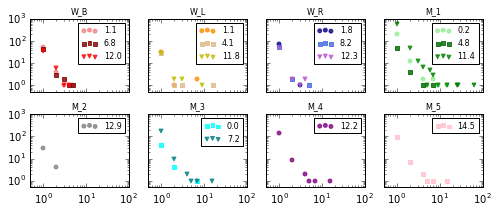

In [5]:
#count distribution plots for each ppt
fig,axarr=plt.subplots(2,4,sharex=True,sharey=True,dpi=600,figsize=(7,3))
name='+'
ppt_ind=-1
for i in range(len(obz)):

    if obz[i].name[2]!=name:
        pl_t=[[],[]]
        ppt_ind+=1
        name=obz[i].name[2]
        
    ax=axarr[int(ppt_ind/4)][ppt_ind%4]
    
    Nx=obz[i].Nx

    ss=ax.scatter(range(1,len(Nx)),Nx[1:],color=obz[i].c,marker=obz[i].m,s=15,alpha=0.8)
    pl_t[0].append(ss)
    pl_t[1].append(obz[i].t)
    
    ax.loglog()
    ax.set_title(obz[i].name[:3],fontsize=8)
    ax.legend(pl_t[0],pl_t[1],fontsize=8,loc=1)

ax.set_xlim([0.5,1e2])
ax.set_ylim([0.5,1e3])
plt.tight_layout()
plt.savefig('figures/obs_N-n.pdf')

In [6]:
#print some sentences about the data
num_clones=[]
frac_clones=[]
frac_cells_in_clones=[]
cells_in_clones=[]
cells_in_max_clone=[]
frac_in_max_clone=[]
for i in range(len(obz)):
    ob=obz[i]
    num_clones.append(sum(obz[i].Nx[2:]))
    frac_clones.append(sum(obz[i].Nx[2:])/sum(obz[i].Nx))
    
    NS=obz[i].Nx*np.arange(len(obz[i].Nx)) #number of cells N(n)*n
    cells_in_clones.append(sum(NS[2:])) #observed sequence clones
    frac_cells_in_clones.append(sum(NS[2:])/obz[i].N) #observed sequence clones
    cells_in_max_clone.append(NS[-1])
    frac_in_max_clone.append(NS[-1]/ob.N)
    
def printer(x):
    print(np.min(x),'-',np.max(x),'mean: ', np.mean(x))
    
print('number of observed sequences that were clonal')
printer(num_clones)
print('fraction of observed sequences that were clonal')
printer(frac_clones)
print('number of cells observed from clonal populations')
printer(cells_in_clones)
print('fraction of cells observed from clonal populations')
printer(frac_cells_in_clones)
print('number of cells observed in the largest clone')
printer(cells_in_max_clone)
print('fraction of cells observed in the largest clone')
printer(frac_in_max_clone)

number of observed sequences that were clonal
1 - 83 mean:  11.7647058824
fraction of observed sequences that were clonal
0.0131578947368 - 0.186046511628 mean:  0.103469024
number of cells observed from clonal populations
3 - 358 mean:  45.4705882353
fraction of cells observed from clonal populations
0.0384615384615 - 0.42 mean:  0.281034493309
number of cells observed in the largest clone
3 - 62 mean:  12.5294117647
fraction of cells observed in the largest clone
0.0384615384615 - 0.32 mean:  0.122685421917


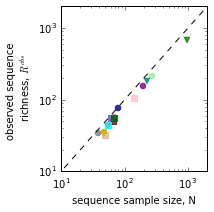

In [7]:
#plot “HIV sequence sample size (N)” (x-axis) versus “Number of distinct sequences (N(1)+2N(2)+3n(3)+….) (y-axis)

#samples plotted out, most have <50
plt.figure(figsize=(3,3),dpi=600)
xtz=[]
for i in range(len(obz)):
    plt.scatter(obz[i].N,obz[i].Robs,color=obz[i].c,marker=obz[i].m,s=30,alpha=0.8)
    xtz.append(obz[i].name)

plt.loglog(np.arange(1e4),np.arange(1e4),ls='--',color='k',lw=1)
plt.xlabel('sequence sample size, N')
plt.ylabel('observed sequence \n richness, $R^{obs}$')
#plt.yticks(range(len(obz)),xtz,rotation=0,fontsize=10)
plt.ylim([10,2e3])
plt.xlim([10,2e3])
#plt.ylim([-1,len(obz)])

plt.tight_layout()
plt.savefig('figures/obs_NvsR.pdf')

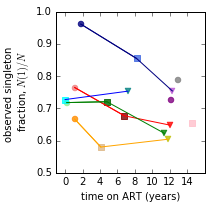

In [8]:
#data fraction singleton
plt.figure(figsize=(3,3),dpi=600)

pltz=[[],[]]
name='+'
ppt_ind=-1
for i in range(len(obz)):

    if obz[i].name[2]!=name:
        ppt_t=[]
        ppt_RN=[]
        name=obz[i].name[2]
        ppt_ind+=1

    ppt_t.append(obz[i].t)
    sf=obz[i].Nx[1]/obz[i].N
    ppt_RN.append(sf)

    plt.scatter(obz[i].t,sf,color=obz[i].c,marker=obz[i].m,s=30,alpha=0.8)
    lp=plt.plot(ppt_t,ppt_RN,color=cz_ppts[ppt_ind],lw=1,ls='-')

    #pltz[0].append(lp)
    #pltz[1].append(obz[i].name[:3])
    
#plt.legend(pltz[1])
plt.xticks(range(0,16,2))
plt.xlim([-1,16])
plt.ylabel('observed singleton \n fraction, $N(1)/N$')
plt.xlabel('time on ART (years)')
plt.ylim([0.5,1])

plt.tight_layout()
plt.savefig('figures/obs_sf.pdf')

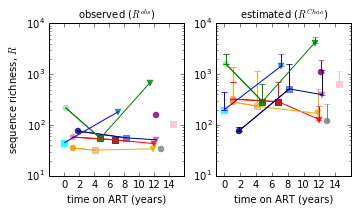

In [9]:
#plot richness and estimates
t_all=np.array([obz[i].t for i in range(len(obz))])
N_all=np.array([obz[i].N for i in range(len(obz))])
datapoints_all=np.array([sum(obz[i].Nx>0) for i in range(len(obz))])

#observed
Ro_all=[obz[i].Robs for i in range(len(obz))]
LRo=st.linregress(t_all,np.log10(Ro_all))

#estimated Chao
Rc_all=[obz[i].Rchao for i in range(len(obz))]
LRc=st.linregress(t_all,np.log10(Rc_all))

#jacknife estimators (not used for now)
Rj1_all=[obz[i].Rj1 for i in range(len(obz))]
Rj2_all=[obz[i].Rj2 for i in range(len(obz))]
LRj1=st.linregress(t_all,np.log10(Rj1_all))
LRj2=st.linregress(t_all,np.log10(Rj2_all))


plt.figure(figsize=(5,3),dpi=rez)

name='+'
ppt_ind=-1
for i in range(len(obz)):

    if obz[i].name[2]!=name:
        ppt_t=[]
        ppt_Robs=[]
        ppt_Rchao=[]
        ppt_RCI=[]
        ppt_Rj1=[]
        ppt_Rj2=[]
        name=obz[i].name[2]
        ppt_ind+=1

    ob=obz[i]
    
    ppt_t.append(ob.t)
    ppt_Robs.append(ob.Robs)
    ppt_Rchao.append(ob.Rchao)
    ppt_RCI.append(ob.CI)
    
    plt.subplot(121)
    plt.scatter(ob.t,ob.Robs,color=ob.c,marker=ob.m,s=30,alpha=0.8)
    plt.semilogy(ppt_t,ppt_Robs,color=cz_ppts[ppt_ind],lw=1,ls='-')
    
    plt.subplot(122)
    plt.scatter(ob.t,ob.Rchao,color=ob.c,marker=ob.m,s=30,alpha=0.8)
    plt.errorbar(ppt_t,ppt_Rchao,yerr=(np.zeros(len(ppt_RCI)),ppt_RCI),color=cz_ppts[ppt_ind],lw=1,ls='-')
    plt.yscale('log')

tt=np.linspace(0,max(t_all),100) #time series for linear regression
yo=10**(tt*LRo[0]+LRo[1])
yc=10**(tt*LRc[0]+LRc[1])

plt.subplot(121)
#plt.semilogy(tt,yo,lw=5,ls='-',color='gray',alpha=0.3)
plt.title(r'observed ($R^{obs}$)',fontsize=10)
plt.ylabel('sequence richness,' + r' $R$') 
plt.xticks(range(0,16,2))
plt.ylim([10,1e4])
plt.xlabel('time on ART (years)')    

plt.subplot(122)
#plt.semilogy(tt,yc,lw=5,ls='-',color='gray',alpha=0.3)
plt.title(r'estimated ($R^{Chao}$)',fontsize=10)
plt.xlim([-1,16])
plt.xticks(range(0,16,2))
plt.ylim([10,1e4])
plt.xlabel('time on ART (years)')    

plt.tight_layout()

plt.savefig('figures/nonparametric_richness.pdf')

In [10]:
#helper normalizer for probability distributions
def normalize(pxx):
    return pxx/sum(pxx)

#functions to auto-fit
def fit_models(ob):

    xd=np.arange(1,len(ob.Nx)) #xrange for data
    d=ob.Nx[1:] #the count data
    
    #define each model, return negative log-likelihood, 
    #the number we want to minimize (to maximize the likelihood)
    def autofit_pwl1(param):            
        al=param
        pxd=normalize(xd**(-al))
        logL=np.sum(d*np.log(pxd))
        return -logL

    def autofit_pwl2(param):            
        al1,al2,phi=param
        #pxd=normalize(xex**(-al1)+phi*xex**(-al2))
        pxd=normalize(xd**(-al1)+10**phi*xd**(-10**al2)) #exponential parameter values
        logL=np.sum(d*np.log(pxd))        
        return -logL

    def autofit_ilog(param):            
        w=1+10**param
        #w=param
        pxd=normalize(1/np.log(w*xd))
        logL=np.sum(d*np.log(pxd))
        return -logL

    def autofit_gamm(param):            
        al,lam=param
        pxd=normalize(1/sp.special.gamma(al)*lam**al*xd**(al-1)*np.exp(-lam*xd))
        logL=np.sum(d*np.log(pxd))
        return -logL

    #initial conditions for model fits
    pwl1_0=(2)
    pwl2_0=(4,-3,-2)
    ilog_0=(-3)
    #gamm_0=(1,1)

    #fit each function (need to figuyre out bounds)
    bf_pwl1=sp.optimize.minimize(autofit_pwl1,pwl1_0,method='Nelder-Mead') #best fit powerlaw 1
    bf_pwl2=sp.optimize.minimize(autofit_pwl2,pwl2_0,method='Nelder-Mead') #best fit powerlaw biphasic

    #bf_pwl1=sp.optimize.minimize(autofit_pwl1,pwl1_0,bounds=((0,10),),method='Levenberg-Marquardt') #best fit powerlaw 1
    #bf_pwl2=sp.optimize.minimize(autofit_pwl2,pwl2_0,bounds=((0,10),(None,0),(None,0))) #best fit powerlaw biphasic
    #bf_ilog=sp.optimize.minimize(autofit_ilog,ilog_0,bounds=((-5,0),)) #best fit inv-log
    #bf_gamm=sp.optimize.minimize(autofit_gamm,gamm_0,bounds=((None,None),(None,None))) #best fit gamma function

    return bf_pwl1,bf_pwl2#,bf_ilog,bf_gamm



In [11]:
#functions to auto-fit
def fit_models_cdf(ob):

    xd=np.arange(1,len(ob.Nx)) #xrange for data
    d=np.cumsum(ob.px[1:]) #the count data
    
    #define each model, return negative log-likelihood, 
    #the number we want to minimize (to maximize the likelihood)
    def autofit_pwl1(param):            
        al=param
        pxd=np.cumsum(normalize(xd**(-al)))
        KS=max(np.abs(pxd-d))
        return KS

    def autofit_pwl2(param):            
        al1,al2,phi=param
        pxd=np.cumsum(normalize(xd**(-al1)+10**phi*xd**(-10**al2))) #exponential parameter values
        KS=max(np.abs(pxd-d))
        return KS

    def autofit_ilog(param):            
        w=1+10**param
        pxd=normalize(1/np.log(w*xd))
        KS=max(np.abs(pxd-d))
        return KS

    def autofit_gamm(param):            
        al,lam=param
        pxd=np.cumsum(normalize(1/sp.special.gamma(al)*lam**al*xd**(al-1)*np.exp(-lam*xd)))
        logL=np.sum(d*np.log(pxd))
        return -logL

    #initial conditions for model fits
    pwl1_0=(2)
    pwl2_0=(4,-3,-2)
    ilog_0=(-4)

    #fit each function (need to figuyre out bounds)
    bf_pwl1=sp.optimize.minimize(autofit_pwl1,pwl1_0,bounds=((0,None),)) #best fit powerlaw 1
    bf_pwl2=sp.optimize.minimize(autofit_pwl2,pwl2_0,bounds=((0,None),(None,0),(None,0))) #best fit powerlaw biphasic

    #bf_pwl1=sp.optimize.minimize(autofit_pwl1,pwl1_0,method='Nelder-Mead') #best fit powerlaw 1
    #bf_pwl2=sp.optimize.minimize(autofit_pwl2,pwl2_0,method='Nelder-Mead') #best fit powerlaw biphasic
    #bf_ilog=sp.optimize.minimize(autofit_ilog,ilog_0,bounds=((None,0),)) #best fit inv-log
    #bf_gamm=sp.optimize.minimize(autofit_gamm,gamm_0,bounds=((None,None),(None,None))) #best fit gamma function

    return bf_pwl1,bf_pwl2#,bf_ilog,bf_gamm



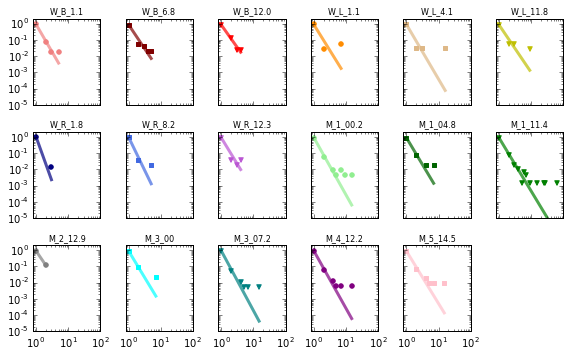

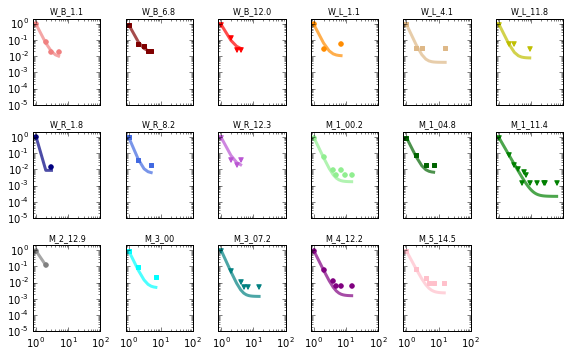

In [12]:
#supplementary figures, fit each participant separately for each model

fig1,aa1=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))
fig2,aa2=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))
#fig3,aa3=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))
#fig4,aa4=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))

axz=[aa1,aa2]#,aa3,aa4]

likelihood_comparison=np.zeros([len(axz),len(obz)]) #to compare likelihoods later

bf_list=[]
#loop over participant timepoints
for i in range(len(obz)):
    ob=obz[i] #the object
    xd=range(1,len(ob.Nx)) #data range
    #bf_models=fit_models(ob) #fit all models
    bf_models=fit_models_cdf(ob) #fit all models
    bf_list.append(bf_models)
    #loop over models
    for j in range(len(axz)):
        ax=axz[j][int(i/6)][i%6]
        ax.set_title(ob.name,fontsize=8)

        #compute the models for the data range
        if j==0:
            al,=bf_models[0].x
            pxd=normalize(xd**(-al))
            #print(al)
        if j==1:
            al1=bf_models[1].x[0]
            al2=bf_models[1].x[1]
            phi=bf_models[1].x[2]
            pxd=normalize(xd**(-al1)+10**phi*xd**(-10**al2))
            #print(al1,10**al2,10**phi)
        if j==2:
            w,=1+10**bf_models[2].x
            pxd=normalize(1./np.log(w*xd))
            print(w)
        if j==3:
            al=bf_models[3].x[0]
            lam=bf_models[3].x[1]
            pxd=normalize(1/sp.special.gamma(al)*lam**al*xd**(al-1)*np.exp(-lam*xd))
               
        logL=np.sum(ob.Nx[1:]*np.log(pxd))
        likelihood_comparison[j,i]=logL #add likelihood from best fit
          
        #plot the best fit models on each plot
        ax.scatter(xd,ob.px[1:],color=ob.c,marker=ob.m,s=20)
        ax.loglog(xd,pxd,color=ob.c,lw=3,alpha=0.7)
        ax.set_xlim([0.8,1e2])
        ax.set_ylim([1e-5,2])

#remove last axis      
for j in range(len(axz)):
    axz[j][2][5].remove()

fig1.tight_layout()
fig1.savefig('figures/best_fit-pwl1.pdf')

fig2.tight_layout()
fig2.savefig('figures/best_fit-pwl2.pdf')

#fig3.tight_layout()
#fig3.savefig('figures/best_fit-ilog.pdf')
#fig4.tight_layout()
#fig4.savefig('figures/best_fit-gamm.pdf')


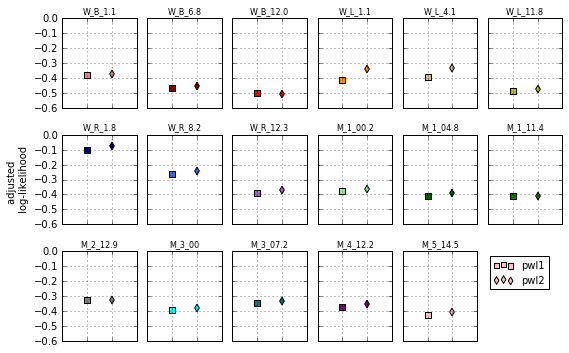

In [13]:
#compare model fits with likelihood
fig,aa=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))

mz=['s','d','o'] #leave out gamma
modelz=['pwl1','pwl2','inv-log','gamma']

#loop over participant timepoints
for i in range(len(obz)):
    ob=obz[i]
    ax=aa[int(i/6)][i%6]
    #loop over models
    for j in range(len(axz)):
        ax.scatter(j,likelihood_comparison[j,i]/ob.N,c=ob.c,marker=mz[j],s=30,lw=1) #scatter likelihoods to compare models
    ax.set_title(ob.name,fontsize=8)
    ax.grid()

ax.set_xlim([-1,2])
ax.set_xticks(range(len(mz)))
ax.set_xticklabels([])
ax.legend(modelz[:len(mz)],bbox_to_anchor=(1.1, 1), loc=2,fontsize=10)
#for j in range(len(mz)):
#    ax=aa[2][5]
#    ax.scatter(j,10,c='k',marker=mz[j],s=30,lw=1) #scatter likelihoods to compare models
#plt.legend(modelz[:len(mz)],fontsize=10)
#ax.set_yticklabels([])
#ax.set_ylim([0,1])
aa[2][5].remove()
aa[1][0].set_ylabel('adjusted \n log-likelihood')

fig.tight_layout()
fig.savefig('figures/likelihood_allcomps.pdf')   


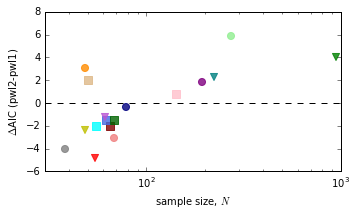

In [14]:
#correlate fits with sample size
num_params=[1,3,1,3]

#plot likelihood ratios
plt.figure(figsize=(5,3),dpi=rez)

#compute the information criteria
IC=np.zeros([len(axz),len(obz)]) #to compare likelihoods later
for i in range(len(axz)):
    #IC[i,:]=2*num_params[i]-2*likelihood_comparison[i,:]; fn='AIC'; #AIC
    IC[i,:]=np.log(datapoints_all)*num_params[i]-2*likelihood_comparison[i,:]; fn='BIC' #BIC

#plot the delta IC, depending on the IC chosen
for i in range(len(obz)):
    plt.scatter(N_all[i],IC[0,i]-IC[1,i],marker=obz[i].m,color=obz[i].c,s=50,lw=1,alpha=0.8) #scatter likelihoods to compare models

plt.xscale('log')
plt.ylabel('$\Delta$'+fn+' (pwl2-pwl1)')
plt.xlabel('sample size, $N$')
plt.axhline(0,color='k',ls='--',lw=1)
plt.xlim([30,1e3])
plt.tight_layout()
plt.savefig('figures/'+fn+'_comp.pdf')   


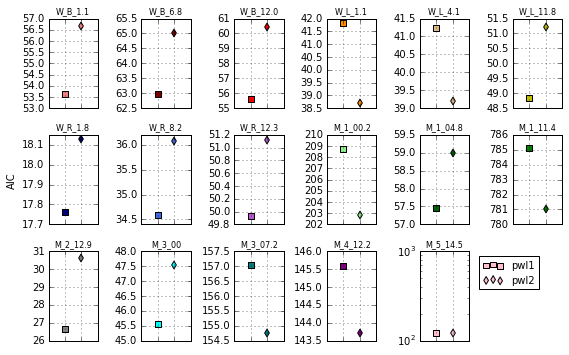

In [15]:
#compare model fits with AIC
fig,aa=plt.subplots(3,6,sharex=True,sharey=False,dpi=600,figsize=(8,5))

mz=['s','d','o'] #leave out gamma
modelz=['pwl1','pwl2','inv-log','gamma']
num_params=[1,3,1,2] #for BIC

#loop over participant timepoints
for i in range(len(obz)):
    ob=obz[i]
    ax=aa[int(i/6)][i%6]
    #loop over models
    for j in range(len(axz)):
        ax.scatter(j,IC[j,i],c=ob.c,marker=mz[j],s=30,lw=1) #scatter likelihoods to compare models
    ax.set_title(ob.name,fontsize=8)
    ax.grid()

ax.set_xticks(range(len(axz)))
ax.set_xticklabels([])
ax.set_xlim([-1,2])
ax.legend(modelz[:len(axz)],bbox_to_anchor=(1.1, 1), loc=2,fontsize=10)
aa[2][5].remove()
aa[1][0].set_ylabel(fn)
plt.yscale('log')
fig.tight_layout()
fig.savefig('figures/'+fn+'_allcomps.pdf')   


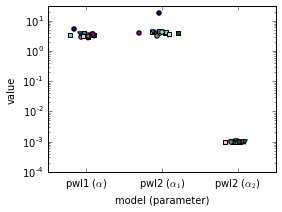

In [16]:
#compare powerlaw model exponents
jit=0.1 #jitter factor
plt.figure(figsize=(4,3),dpi=rez)
al_list=[]; al1_list=[]; al2_list=[]
for i in range(len(obz)):
    ob=obz[i] #the object
    bf_models=bf_list[i]
    #loop over models
    for j in range(len(axz)):
        #compute the models for the data range
        if j==0:
            al_list.append(bf_models[0].x)
            #plt.subplot(131)
            plt.scatter(np.random.normal(1,jit),al_list[i],c=ob.c,marker=ob.m)
            #plt.yscale('log')
            #plt.xticks([1],[r'pwl1 ($\alpha$)'])
        if j==1:
            al1_list.append(bf_models[1].x[0])
            #plt.subplot(132)
            plt.scatter(np.random.normal(2,jit),al1_list[i],c=ob.c,marker=ob.m)
            #plt.xticks([2],[r'pwl2 ($\alpha_1$)'])
            #plt.yscale('log')
            #plt.ylim([1e-4,3e1])
            
            al2_list.append(10**bf_models[1].x[1])
            #plt.subplot(133)            
            plt.scatter(np.random.normal(3,jit),al2_list[i],c=ob.c,marker=ob.m)
            #plt.xticks([3],[r'pwl2 ($\alpha_2$)'])
            #plt.yscale('log')
            #plt.ylim([1e-4,3e1])

#plt.boxplot([al_list,al1_list,al2_list],positions=[1,2,3])
plt.xticks([1,2,3],[r'pwl1 ($\alpha$)',r'pwl2 ($\alpha_1$)',r'pwl2 ($\alpha_2$)'])
plt.yscale('log')
plt.ylim([1e-4,3e1])
plt.xlabel('model (parameter)')
plt.ylabel('value')
plt.tight_layout()
plt.savefig('figures/model_parameters.pdf')


In [17]:
#now extrapolate all models

thL=-5.2e-4*365 #decay rate in years

sf_ex=np.zeros([len(mz),len(obz)]) #singleton fraction
R_ex=np.zeros([len(mz),len(obz)]) #extrapolated richness
L_ex=np.zeros([len(mz),len(obz)]) #extrapolated reservoir size

Nex_list=[[],[],[]]
aex_list=[[],[],[]]
rex_list=[[],[],[]]

#loop over participant timepoints
for i in range(len(obz)):
    ob=obz[i] #the object
    xd=range(1,len(ob.Nx)) #data range
    bf_models=bf_list[i]
    
    L=1e6*np.exp(thL*ob.t)
    maxx=int(np.sqrt(8*L)/2) #solving sum_1^n i = n(n+1)/2 = L
    xex=np.arange(1,maxx+1) #extrapolated range (maximum possible if all had 1)
    
    #loop over models
    for j in range(len(axz)):
        #compute the models for the data range
        if j==0:
            al=bf_models[0].x
            pxd=normalize(xex**(-al))
        if j==1:
            al1=bf_models[1].x[0]
            al2=bf_models[1].x[1]
            phi=bf_models[1].x[2]
            #pxd=normalize(xex**(-al1)+phi*xex**(-al2))
            pxd=normalize(xex**(-al1)+10**phi*xex**(-10**al2))
        if j==2:
            #w=bf_models[2].x
            w=1+10**bf_models[2].x
            pxd=normalize(1./np.log(w*xex))
        if j==3:
            al=bf_models[3].x[0]
            lam=bf_models[3].x[1]
            pxd=normalize(1/sp.special.gamma(al)*lam**al*xex**(al-1)*np.exp(-lam*xex))

        #get the right reservoir volume (do it twice for rounding)
        Ntot=np.sum(pxd*xex) #total number of cells in reservoir
        C=L/Ntot #constant to make reservoir volume right
        Nex=np.round(C*pxd)
        Ntot=np.sum(Nex*xex) #check volume
        
        Nex_list[j].append(Nex)
        
        #rank abundance distributions
        ab=[]
        for jj in range(len(Nex)):
            ab.append(list(np.ones(int(Nex[jj]))*(jj+1)))
        abund=np.flipud(sum(ab, [])) #flatten the list
        ranks=np.arange(1,len(abund)+1)
                
        aex_list[j].append(abund)
        rex_list[j].append(np.arange(1,len(abund)+1))

        sf_ex[j,i] = Nex[0]/Ntot
        R_ex[j,i] = max(ranks[abund>0])
        L_ex[j,i] = Ntot

    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


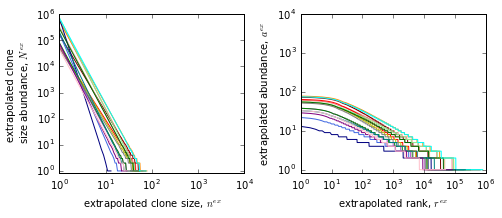

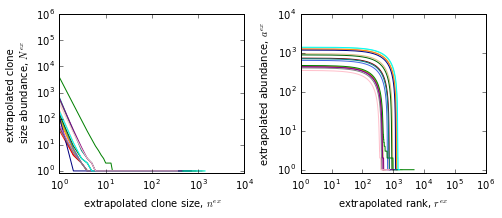

In [18]:
#plots
for j in range(len(axz)):
    plt.figure(figsize=(7,3),dpi=rez)
    for i in range(len(obz)):

        ob=obz[i]
        
        #probability distributions
        plt.subplot(121)
        Nex=Nex_list[j][i]
        xex=np.arange(1,len(Nex)+1)
        plt.loglog(xex,Nex,color=ob.c)
        #plt.title(modelz[j],fontsize=10)
        plt.xlim([1,1e4])
        plt.ylim([0.8,1e6])
        plt.xticks(10**np.arange(5))
        plt.yticks(10**np.arange(7))
        plt.minorticks_off()
        plt.xlabel('extrapolated clone size, $n^{ex}$')
        plt.ylabel('extrapolated clone \n size abundance, $N^{ex}$')

        #rank abundance distributions
        abund=aex_list[j][i]
        ranks=rex_list[j][i]

        plt.subplot(122)
        plt.loglog(ranks,abund,color=ob.c)
        plt.ylim([0.8,1e4])
        plt.xlim([1,1e6])
        plt.xticks(10**np.arange(7))
        plt.yticks(10**np.arange(5))
        plt.minorticks_off()
        plt.xlabel('extrapolated rank, $r^{ex}$')
        plt.ylabel('extrapolated abundance, $a^{ex}$')
    plt.tight_layout()
    plt.savefig('figures/ex_dists_'+modelz[j]+'.pdf')




In [19]:
#functions for sampling from distributions

#sample from extrapolated count distribution
def sample_px(xex,Nex,ns):
    nz=0
    sim_samples=[]
    while nz<ns:
        max_poss=ns-nz #max possible clone size based on samples remaining
        custm = st.rv_discrete(name='custm', values=(xex[:max_poss], Nex[:max_poss]/sum(Nex[:max_poss])))
        sampz=custm.rvs(size=1)
        sim_samples.append(sampz[0])
        nz+=sampz
    #print(sim_samples)
    Nsx=np.bincount(sim_samples)
    return Nsx
    

/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


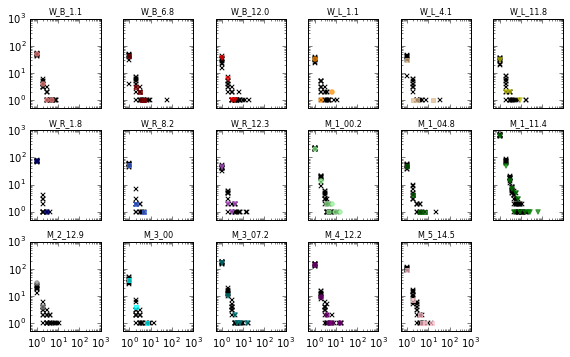

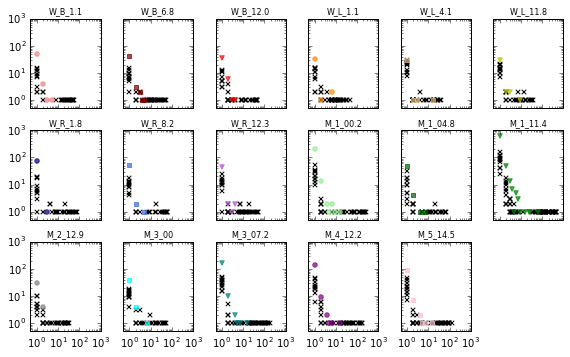

In [20]:
#supplementary figures, plot sampled distributions against participant data separately for each model

fig1,aa1=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))
fig2,aa2=plt.subplots(3,6,sharex=True,sharey=True,dpi=600,figsize=(8,5))
axz=[aa1,aa2]

xsx=np.arange(1000) #maximum value for sampels

num_replicates=10
#lsz=['-','-.']
#loop over participant timepoints
for i in range(len(obz)):
    ob=obz[i] #the object
    xd=range(1,len(ob.Nx)) #data range
    #loop over models
    for j in range(len(axz)):
        #ax=aa1[[int(i/6)][i%6]
        ax=axz[j][int(i/6)][i%6]
        ax.set_title(ob.name,fontsize=8)

        abund=aex_list[j][i]
        ranks=rex_list[j][i]
        Nex=Nex_list[j][i]
        xex=np.arange(1,len(Nex)+1)
                
        Nsx=np.zeros([num_replicates,1000])
        for k in range(num_replicates):
            spx=sample_px(xex,Nex,ob.N)
            Nsx[k,:len(spx)]=spx
            #sra=np.bincount(np.random.multinomial(ob.N,abund/sum(abund))) #try sampling from rank abundance
            #Nsx[k,:len(sra)]=sra
            ax.scatter(xsx[Nsx[k,:]>0],Nsx[k,Nsx[k,:]>0],color='k',marker='x',s=20)

        
        #plot the best fit models on each plot
        ax.scatter(xd,ob.Nx[1:],color=ob.c,marker=ob.m,s=20,alpha=0.7)
        
        #or plot average from replicates
        #if num_replicates>1:
        #    avg_Nsx=np.mean(Nsx,0)
        #else:
        #    avg_Nsx=Nsx[0]
        #ax.plot(xsx[avg_Nsx>0],avg_Nsx[avg_Nsx>0],color='k',ls=lsz[j])#,marker='x',s=20)
        
        ax.set_xlim([0.5,1e3])
        ax.set_ylim([0.5,1e3])
        #ax.set_ylim([0.5,100])

        ax.set_xscale('log')
        ax.set_yscale('log')

#remove last axis      
for j in range(len(axz)):
    axz[j][2][5].remove()
fig1.tight_layout()
fig1.savefig('figures/sample_bestfit-pwl1.pdf')

fig2.tight_layout()
fig2.savefig('figures/sample_bestfit-pwl2.pdf')


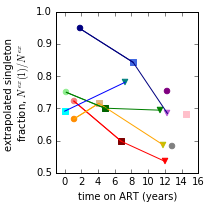

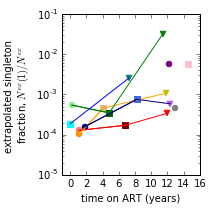

In [21]:
#plot extrapolated singletons
for mo in range(len(axz)):
    plt.figure(figsize=(3,3),dpi=rez)
    name='+'
    ppt_ind=-1
    for i in range(len(obz)):

        if obz[i].name[2]!=name:
            ppt_obs=[]
            ppt_t=[]
            ppt_all=[]
            ppt_ind+=1
            name=obz[i].name[2]

        sf=sf_ex[mo,i]
        
        ppt_t.append(obz[i].t)
        ppt_all.append(sf)

        plt.scatter(obz[i].t,sf,color=obz[i].c,s=30,marker=obz[i].m)
        plt.plot(ppt_t,ppt_all,color=cz_ppts[ppt_ind],lw=1,ls='-')

    #plt.title(modelz[mo],fontsize=10)
    if mo>0:
        plt.yscale('log')
    plt.xlabel('time on ART (years)')    
    plt.ylabel('extrapolated singleton \n' + r'fraction, $N^{ex}(1)/N^{ex}$') 
    plt.xlim([-1,16])

    plt.tight_layout()
    plt.savefig('figures/ex_sf_'+modelz[mo]+'.pdf')


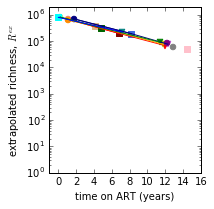

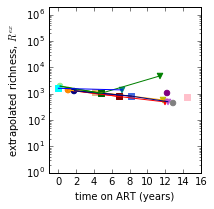

In [22]:
#plot extrapolated richness
all_r=np.zeros([len(obz),len(axz)])
for mo in range(len(axz)):
    plt.figure(figsize=(3,3),dpi=rez)
    name='+'
    ppt_ind=-1
    for i in range(len(obz)):

        if obz[i].name[2]!=name:
            ppt_obs=[]
            ppt_t=[]
            ppt_all=[]
            ppt_ind+=1
            name=obz[i].name[2]

        r=R_ex[mo,i]
        
        all_r[i,mo]=np.log10(r)-np.log10(obz[i].Rchao)
        
        ppt_t.append(obz[i].t)
        ppt_all.append(r)

        plt.scatter(obz[i].t,r,color=obz[i].c,s=30,marker=obz[i].m)
        plt.semilogy(ppt_t,ppt_all,color=cz_ppts[ppt_ind],lw=1,ls='-')

    #plt.title(modelz[mo],fontsize=10)
    plt.xlabel('time on ART (years)')    
    plt.ylabel('extrapolated richness, $R^{ex}$') 
    plt.ylim([1,2e6])
    plt.xlim([-1,16])

    plt.tight_layout()
    plt.savefig('figures/ex_R'+modelz[mo]+'.pdf')


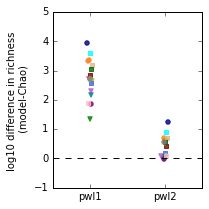

In [23]:
plt.figure(figsize=(3,3),dpi=rez)
#plt.boxplot(all_r)
for mo in range(len(axz)):
    for i in range(len(obz)):
        y = all_r[i,mo]
        x = np.random.normal(mo+1, 0.02)
        plt.scatter(x, y, marker=obz[i].m,color=obz[i].c, alpha=0.8)

plt.axhline(0,color='k',ls='--',lw=1)
plt.xlim([0.5,2.5])
plt.xticks([1,2],modelz)
plt.ylabel('log10 difference in richness \n (model-Chao)')
plt.tight_layout()
plt.savefig('figures/richness_comp.pdf')


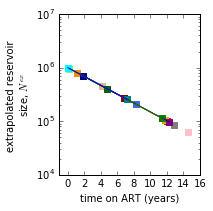

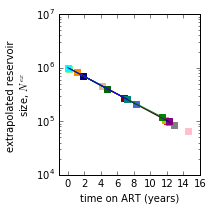

In [24]:
#plot extrapolated reservoir size
for mo in range(len(axz)):
    plt.figure(figsize=(3,3),dpi=rez)
    name='+'
    ppt_ind=-1
    for i in range(len(obz)):

        if obz[i].name[2]!=name:
            ppt_obs=[]
            ppt_t=[]
            ppt_all=[]
            ppt_ind+=1
            name=obz[i].name[2]

        l=L_ex[mo,i]
        
        ppt_t.append(obz[i].t)
        ppt_all.append(l)

        plt.scatter(obz[i].t,l,color=obz[i].c,s=30,marker=ob.m)
        plt.semilogy(ppt_t,ppt_all,color=cz_ppts[ppt_ind],lw=1,ls='-')

    #plt.title(modelz[mo],fontsize=10)
    plt.xlabel('time on ART (years)')    
    plt.ylabel('extrapolated reservoir \n' + r'size, $N^{ex}$') 
    plt.xlim([-1,16])
    plt.ylim([1e4,1e7])

    plt.tight_layout()
    plt.savefig('figures/ex_L'+modelz[mo]+'.pdf')


In [26]:
#rarefaction calculation
def rarefact(rank,abundance,num_samples):
    R=max(rank); L=sum(abundance)
    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        ss=[]
        for j in range(len(abundance)):
            ss.append(sp.misc.comb(L-abundance[j],n))
        r_list[n-1]=(R - sum(ss)/sp.misc.comb(L,n))    
    return n_list,r_list

#function that calculates approximation of rarefaction curve based on rank and abundance data (uses Stirling's)
def rarefaction_approx(rank,abundance,num_samples):
    R=max(rank); L=sum(abundance)
    r_list=np.zeros(num_samples)
    n_list=range(1,num_samples+1)
    for n in n_list:
        r_list[n-1]=R-np.sum((1-abundance/L)**n)
    return n_list,r_list

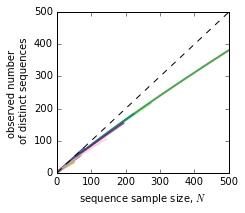

In [ ]:
plt.figure(figsize=(3.5,3),dpi=rez)
for i in range(len(obz)):
    #compute each experimental rarefaction curve
    ranks=np.arange(len(obz[i].abundance))+1
    data_nrare,data_Rrare = rarefact(ranks,obz[i].abundance,num_samples=int(obz[i].N))       
    #data_nrare,data_Rrare = rarefaction_approx(ranks,obz[i].abundance,num_samples=int(obz[i].N))       
    plt.plot(data_nrare,data_Rrare,color=obz[i].c,lw=2,alpha=0.7)
#plt.xlabel('number of samples collected')
#plt.ylabel('expected number of \n distinct strains (observed)')
plt.xlim([0,500])
plt.ylim([0,500])
plt.plot(np.linspace(1,1e3,5),np.linspace(1,1e3,5),ls='--',color='black')
plt.tight_layout()
plt.xlabel('sequence sample size, $N$')
plt.ylabel('observed number \n of distinct sequences')
plt.tight_layout()
plt.savefig('figures/rarefaction_obs.pdf')   



In [ ]:
#plot extrapolated rarefaction
nums=2000
for mo in range(3):
    plt.figure(figsize=(3,3),dpi=rez)

    for i in range(len(obz)):
        abund=aex_list[mo][i]
        
        ranks=np.arange(1,len(abund)+1)
        
        sim_nrare,sim_Rrare=rarefaction_approx(ranks,abund,nums)
        plt.plot(sim_nrare,sim_Rrare,color=obz[i].c)

    #plt.title(modelz[mo],fontsize=10)
    plt.xlabel('sequence sample size, $N^{ex}$')
    plt.ylabel('extrapolated number \n of distinct sequences')
    plt.plot(np.linspace(1,nums,5),np.linspace(1,nums,5),ls='--',color='black')

    plt.tight_layout()
    plt.savefig('figures/rarefaction_ex'+modelz[mo]+'.pdf')
